# Sampling from a diffusion model

<!--- @wandbcode{dlai_03} -->

In this notebook we will sample from the previously trained diffusion model.
- We are going to compare the samples from DDPM and DDIM samplers
- Visualize mixing samples with conditional diffusion models

Comparing model outputs
------

Managing Models
------

Model registry:
a central system of record for your models.
- publish production-ready models
- move model versions through teh lifecycle from staging to production
- collaborate on models across teams
- Audit model lineage across training, evaluation and production
- Automate downstream actions

"We will evaluate the staging model from teh registry. "

Visualizing samples
------

W&B Tables:
- log, query, and analyze tabular data including rich media: images, videos, molecules, etc.
- Compare changes precisely across models.


table = wandb.Table(columns - ['coll', ...]) \
table.add_data(...) \
wandb.log({'predictions': table}) \

In [1]:
from pathlib import Path
from types import SimpleNamespace
import torch
import torch.nn.functional as F
import numpy as np
from utilities_ import *

import wandb

In [2]:
wandb.login(anonymous="allow")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Setting Things Up

In [3]:
# Wandb Params
MODEL_ARTIFACT = "dlai-course/model-registry/SpriteGen:latest"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = SimpleNamespace(
    # hyperparameters
    num_samples = 30,

    # ddpm sampler hyperparameters
    timesteps = 500,
    beta1 = 1e-4,
    beta2 = 0.02,

    # ddim sampler hp
    ddim_n = 25,

    # network hyperparameters
    height = 16,
)

In the previous notebook we saved the best model as a wandb Artifact (our way of storing files during runs). We will now load the model from wandb and set up the sampling loop.

In [4]:
def load_model(model_artifact_name):
    "Load the model from wandb artifacts"
    api = wandb.Api()
    artifact = api.artifact(model_artifact_name, type="model")
    model_path = Path(artifact.download())

    # recover model info from the registry
    producer_run = artifact.logged_by()

    # load the weights dictionary
    model_weights = torch.load(model_path/"context_model.pth",
                               map_location="cpu")

    # create the model using the same parameters as the original one
    model = ContextUnet(in_channels=3,
                        n_feat=producer_run.config["n_feat"],
                        n_cfeat=producer_run.config["n_cfeat"],
                        height=producer_run.config["height"])

    # load the weights into the model
    model.load_state_dict(model_weights)

    # set the model to eval mode
    model.eval()
    return model.to(DEVICE)

In [5]:
nn_model = load_model(MODEL_ARTIFACT)

wandb:   1 of 1 files downloaded.  
<ipython-input-4-034a783abe14>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(model_path/"context_model.pth

## Sampling

We will sample and log the generated samples to wandb.

In [6]:
_, sample_ddpm_context = setup_ddpm(config.beta1,
                                    config.beta2,
                                    config.timesteps,
                                    DEVICE)

Let's define a set of noises and a context vector to condition on.

In [7]:
# Noise vector
# x_T ~ N(0, 1), sample initial noise
noises = torch.randn(config.num_samples, 3,
                     config.height, config.height).to(DEVICE)

# A fixed context vector to sample from
ctx_vector = F.one_hot(torch.tensor([0,0,0,0,0,0,   # hero
                                     1,1,1,1,1,1,   # non-hero
                                     2,2,2,2,2,2,   # food
                                     3,3,3,3,3,3,   # spell
                                     4,4,4,4,4,4]), # side-facing
                       5).to(DEVICE).float()

Let's bring that faster DDIM sampler from the diffusion course.

In [8]:
sample_ddim_context = setup_ddim(config.beta1,
                                 config.beta2,
                                 config.timesteps,
                                 DEVICE)

### Sampling:
let's compute ddpm samples as before

In [9]:
ddpm_samples, _ = sample_ddpm_context(nn_model, noises, ctx_vector)

  0%|          | 0/500 [00:00<?, ?it/s]

For DDIM we can control the step size by the `n` param:

In [10]:
# faster, but compromise on the qualities.
ddim_samples, _ = sample_ddim_context(nn_model,
                                      noises,
                                      ctx_vector,
                                      n=config.ddim_n)

  0%|          | 0/25 [00:00<?, ?it/s]

### Visualizing generations on a Table
Let's create a `wandb.Table` to store our generations

In [11]:
table = wandb.Table(columns=["input_noise", "ddpm", "ddim", "class"])

We can add the rows to the table one by one, we also cast images to `wandb.Image` so we can render them correctly in the UI

In [12]:
for noise, ddpm_s, ddim_s, c in zip(noises,
                                    ddpm_samples,
                                    ddim_samples,
                                    to_classes(ctx_vector)):

    # add data row by row to the Table
    table.add_data(wandb.Image(noise),
                   wandb.Image(ddpm_s),
                   wandb.Image(ddim_s),
                   c)

we log the table to W&B, we can also use `wandb.init` as a context manager, this way we ensure that the run is finished when exiting the manager.

In [13]:
with wandb.init(project="dlai_sprite_diffusion",
                job_type="samplers_battle",
                config=config):

    wandb.log({"samplers_table":table})

wandb: Currently logged in as: alicechen005 (alicechen005-new-york-university). Use `wandb login --relogin` to force relogin


Saving wandb_board_ddim.png to wandb_board_ddim.png


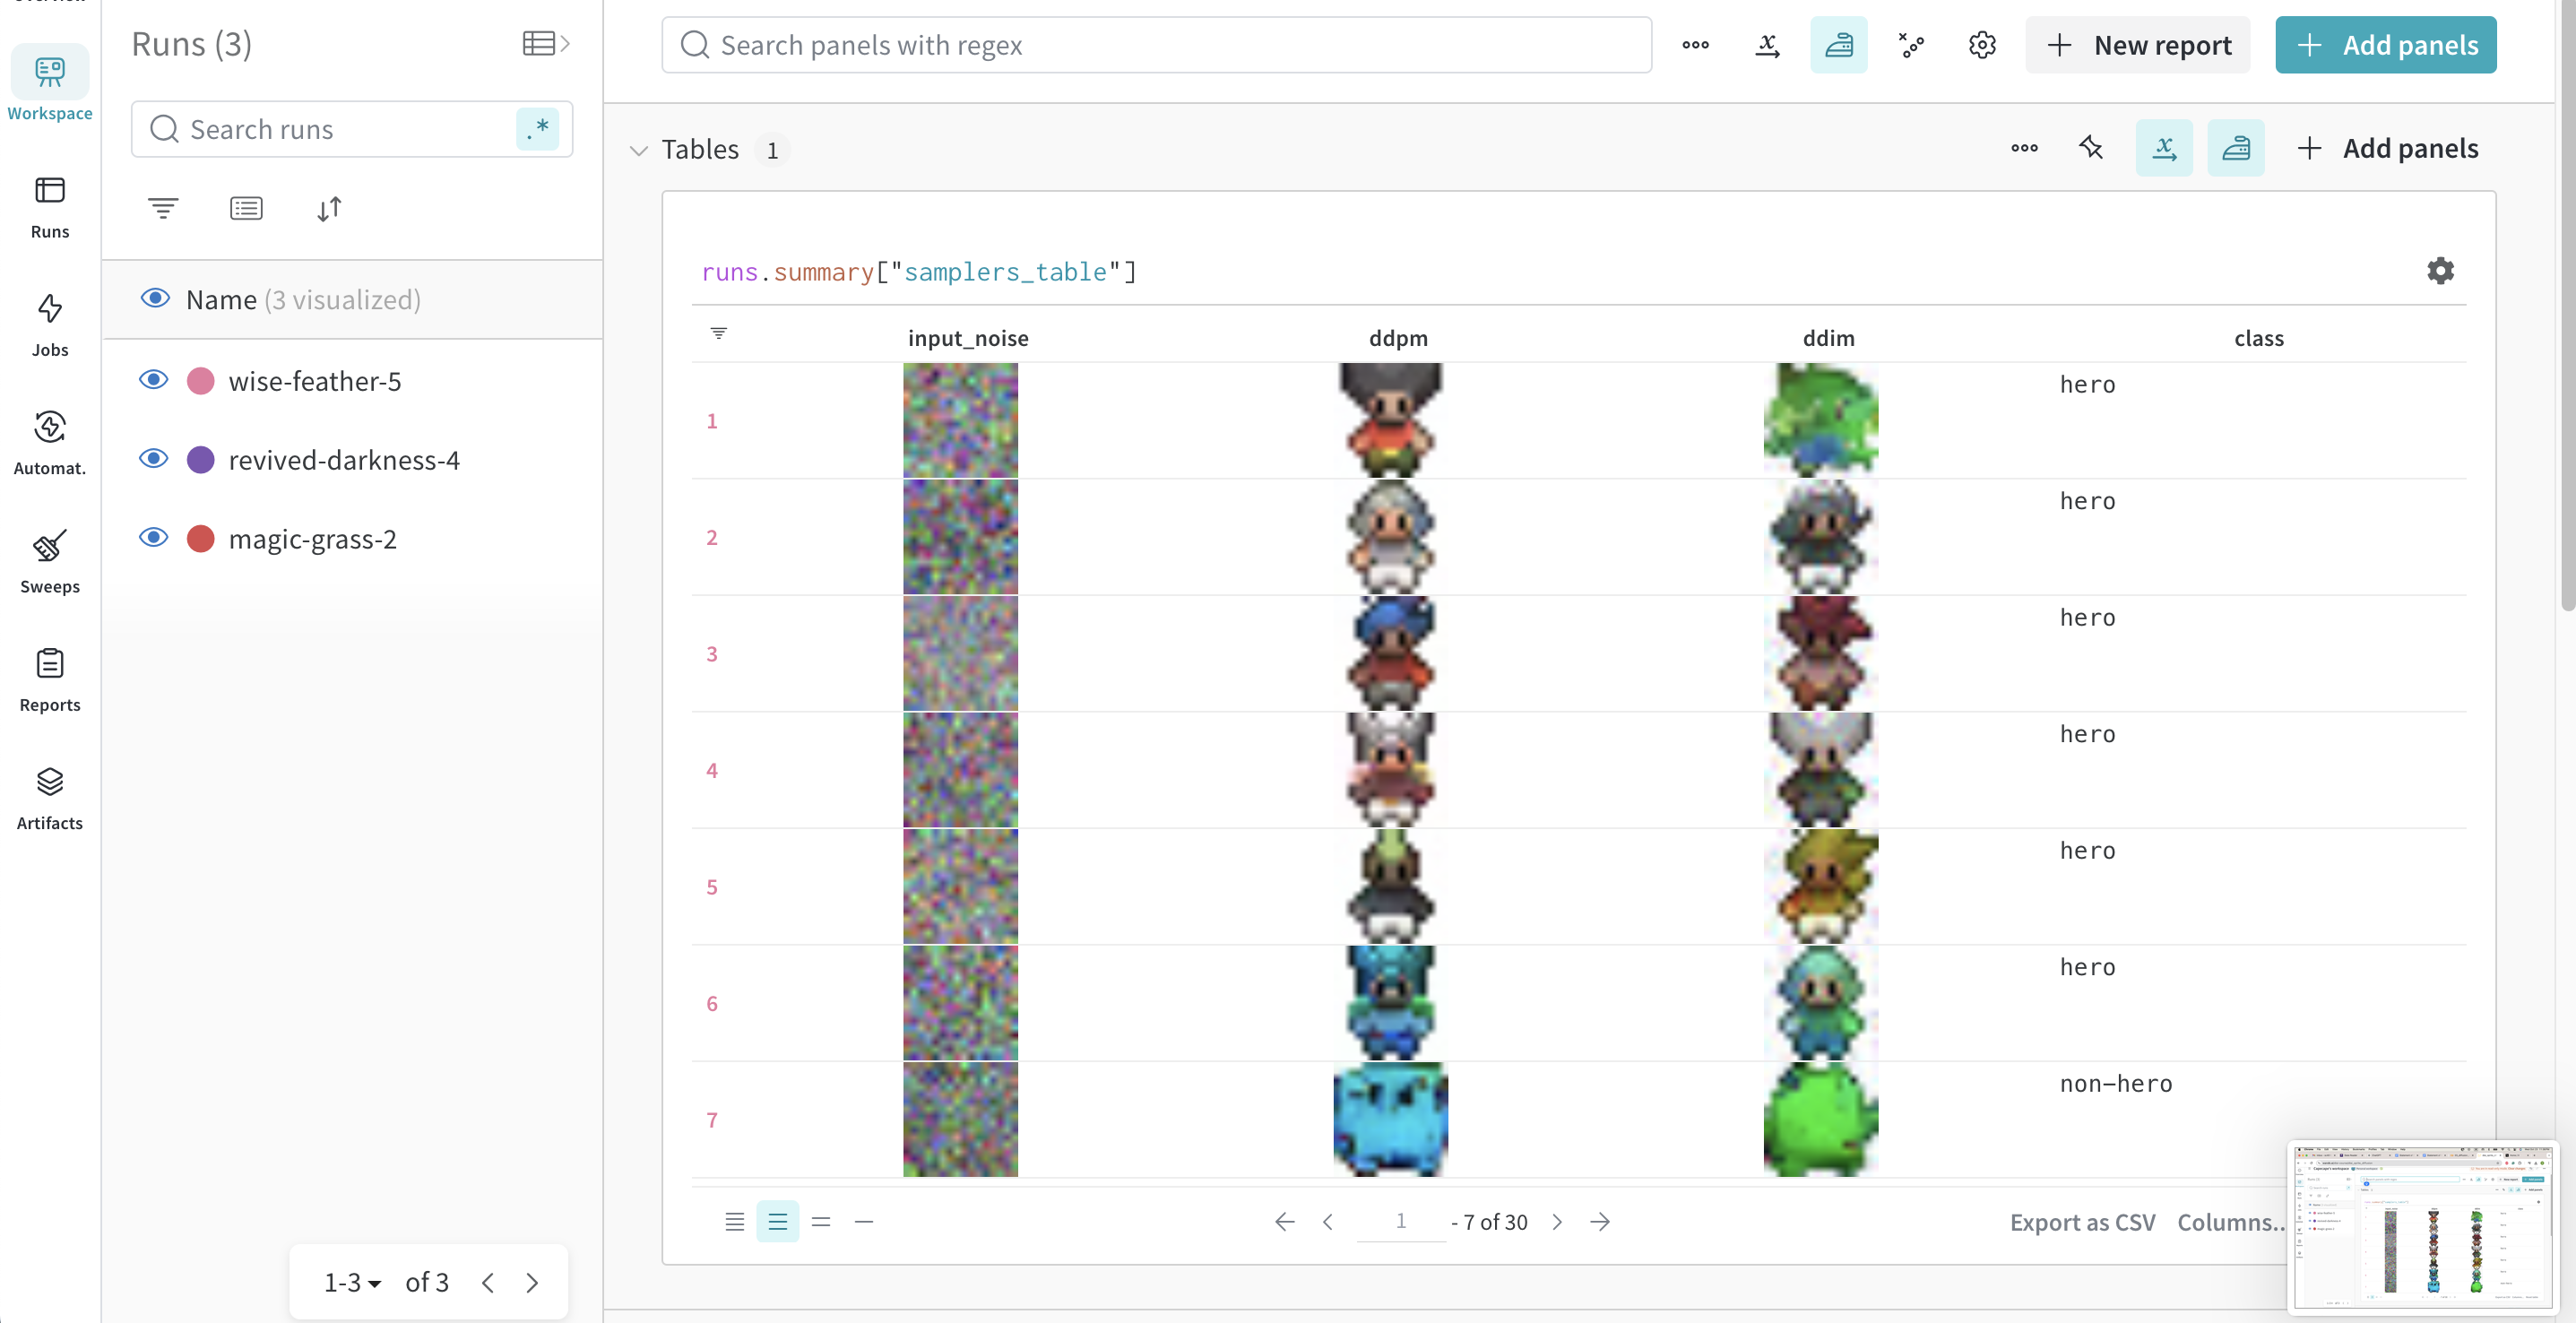

In [17]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='wandb_board_ddim.png')

- different input noise can have different generations.
- somewhat conditioned on the input too, as the outputs can have some similarities.
- can do tabular manipulations, groupby etc.
- can generate customised report with the manipulations and share.